In [20]:
import yfinance as yf
import numpy as np
import pandas as pd

In [21]:
# USER INPUTS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

ticker_symbol = "MSFT"
# Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max Default: 1mo
#timeframe = "10y"
# Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
timeinterval = "1wk"
# Download start date string (YYYY-MM-DD) or _datetime, inclusive
start_date = "2015-10-01"
# Download end date string (YYYY-MM-DD) or _datetime, exclusive
end_date = "2025-10-01"

In [22]:
data = yf.download(ticker_symbol, interval=timeinterval, start=start_date, end=end_date, auto_adjust=True)
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2015-09-28,39.708599,39.708599,38.122695,38.994071,70496900
2015-10-05,41.050522,41.425214,39.821882,39.865450,151471300
2015-10-12,41.399082,41.425226,40.518994,40.937254,118094400
2015-10-19,46.069649,47.115301,40.972100,41.320649,277198300
2015-10-26,45.869236,47.376716,45.747244,45.773384,239455900


In [23]:
data.columns

MultiIndex([( 'Close', 'MSFT'),
            (  'High', 'MSFT'),
            (   'Low', 'MSFT'),
            (  'Open', 'MSFT'),
            ('Volume', 'MSFT')],
           names=['Price', 'Ticker'])

In [24]:
data_clean = data[['Close']].copy()
data_clean.columns = data_clean.columns.droplevel(1)
data_clean.head()

Price,Close
Date,
2015-09-28,39.708599
2015-10-05,41.050522
2015-10-12,41.399082
2015-10-19,46.069649
2015-10-26,45.869236


In [25]:
data_clean['return'] = np.log(data_clean.Close / data_clean.Close.shift(1))
data_clean.head()

Price,Close,return
Date,,
2015-09-28,39.708599,NaN
2015-10-05,41.050522,0.033236
2015-10-12,41.399082,0.008455
2015-10-19,46.069649,0.106896
2015-10-26,45.869236,-0.004360


In [26]:
data_clean.drop(data_clean.index[0], inplace=True)
data_clean.head()

Price,Close,return
Date,,
2015-10-05,41.050522,0.033236
2015-10-12,41.399082,0.008455
2015-10-19,46.069649,0.106896
2015-10-26,45.869236,-0.004360
2015-11-02,47.855972,0.042401


In [27]:
# calculate mu
mu = data_clean['return'].mean()
print(mu)

0.004926634559314492


In [28]:
n = len(data_clean)
var = np.power(data_clean['return'] - mu, 2).sum()/(n-1)
std = np.sqrt(var)
print(var, std)

0.0010184126255594267 0.03191257785825875


In [29]:
skew = np.power((data_clean['return'] - mu)/std, 3).sum()*n/((n-1)*(n-2))
excess_kurtosis = np.power((data_clean['return'] - mu)/std, 4).sum()*n*(n+1)/((n-1)*(n-2)*(n-3)) - 3*(n-1)**2 / ((n-2)*(n-3))
print(skew, excess_kurtosis)

-0.06713835061704153 1.6612981804428406


In [30]:
import matplotlib.pyplot as plt

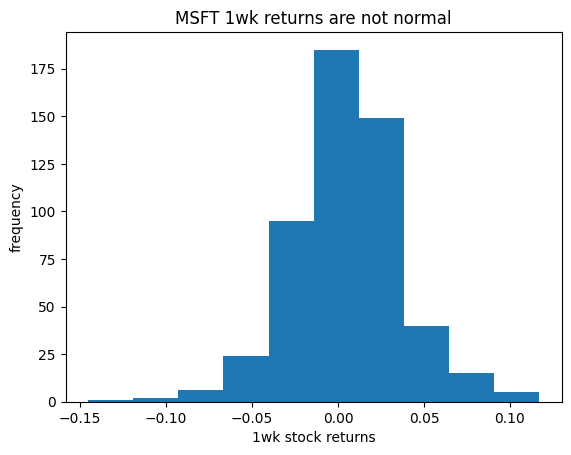

In [31]:
plt.hist(data_clean['return'], bins = 10)
plt.title(ticker_symbol + " " + timeinterval + " returns are not normal")
plt.xlabel(timeinterval + " stock returns")
plt.ylabel("frequency")
plt.show()

In [32]:
import scipy.stats as stats

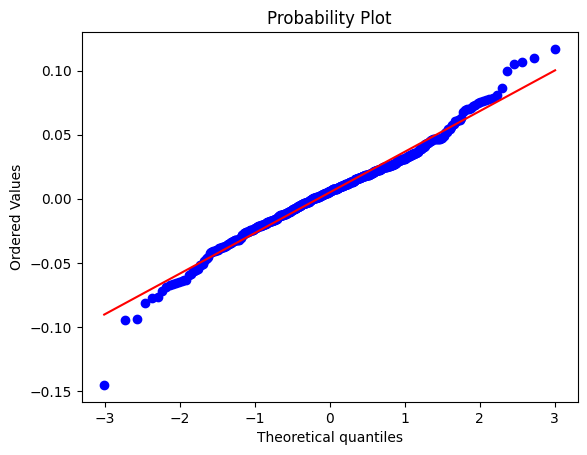

In [33]:
stats.probplot(data_clean['return'], dist="norm", plot=plt)
plt.show()

In [34]:
import statsmodels.api as sm

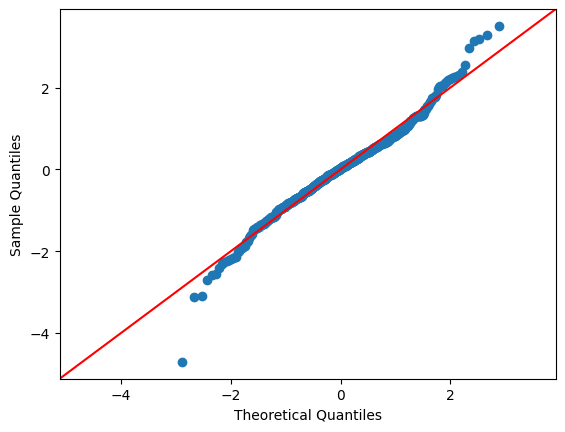

In [35]:
data_clean['s_return'] = (data_clean['return'] - mu)/std
sm.qqplot(data_clean['s_return'], line='45')
plt.show()

In [43]:
from scipy import stats

ks_stat, ks_p = stats.kstest(data_clean['s_return'], 'norm')
print("KS test statistic:", ks_stat)
print("p-value:", ks_p)

KS test statistic: 0.05111247198709745
p-value: 0.1263053521056937


In [45]:
from scipy.stats import shapiro

sh_stat, sh_p = shapiro(data_clean['return'])
print("Shapiro-Wilk test statistic:", sh_stat)
print("p-value:", sh_p)

Shapiro-Wilk test statistic: 0.982506275177002
p-value: 6.437835963879479e-06


In [46]:
from scipy.stats import anderson

result = anderson(data_clean['s_return'], dist='norm')

print("Anderson-Darling statistic:", result.statistic)
print("Critical values:", result.critical_values)
print("Significance levels:", result.significance_level)

Anderson-Darling statistic: 2.0826613948750037
Critical values: [0.572 0.651 0.781 0.911 1.084]
Significance levels: [15.  10.   5.   2.5  1. ]


In [47]:
for sl, cv in zip(result.significance_level, result.critical_values):
    if result.statistic < cv:
        print(f"At {sl}% significance level: fail to reject H₀ (data looks normal)")
    else:
        print(f"At {sl}% significance level: reject H₀ (data not normal)")

At 15.0% significance level: reject H₀ (data not normal)
At 10.0% significance level: reject H₀ (data not normal)
At 5.0% significance level: reject H₀ (data not normal)
At 2.5% significance level: reject H₀ (data not normal)
At 1.0% significance level: reject H₀ (data not normal)
